Downloading the dataset

In [20]:
# from roboflow import Roboflow 
# #Create object of roboflow 
# rf = Roboflow(api_key = "9HhgLNwnngYzUrANLRyF", model_format="multiclass") 
# dataset = rf.workspace().project("dental_imaging").version(1).download(location="./dental_dataset")

Importing required libraries


In [21]:
import torch
from torch import nn
#base library for PyTorch computervision  
import torchvision 
from torchvision.transforms import ToTensor 




Creating dataset

In [22]:
import os
import pandas as pd
from torch.utils.data import Dataset
from PIL import Image


class dentalDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        csv_path = os.path.join(root_dir, "_classes.csv")
        self.df = pd.read_csv(csv_path)

        #filenames
        self.image_names = self.df.iloc[:, 0].values

        #class names from column
        self.class_names = list(self.df.columns[1:])

        #class index
        self.labels = self.df.iloc[:, 1:].values.argmax(axis=1)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_names[idx])
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


Transforming dataset 

In [23]:
from torchvision import transforms

basicTransform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

Transforming train test and validation datasets

In [24]:
train_data = dentalDataset(root_dir="dental_dataset/train",transform = basicTransform )

test_data = dentalDataset(root_dir="dental_dataset/test",transform=basicTransform)

validation_data = dentalDataset(root_dir="dental_dataset/test",transform = basicTransform)



Creating Dataloaders

In [25]:
from torch.utils.data import DataLoader
#setting up batch size 
BATCH_SIZE = 16

#shuffling data every epoch
train_dataloader = DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(dataset = test_data, batch_size = BATCH_SIZE, shuffle = False)
val_dataloader = DataLoader(dataset = validation_data, batch_size = BATCH_SIZE, shuffle = True)


Information of dataloaders

In [26]:
print(f"Dataloaders: {train_dataloader, test_dataloader, val_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of validation dataloader: {len(val_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")


Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x00000235076EECF0>, <torch.utils.data.dataloader.DataLoader object at 0x000002350671C050>, <torch.utils.data.dataloader.DataLoader object at 0x0000023506776150>)
Length of train dataloader: 306 batches of 16
Length of validation dataloader: 39 batches of 16
Length of test dataloader: 39 batches of 16


In [62]:
#Viewing classes 
class_names = train_data.class_names 

print(class_names)

['caries', 'cavity', 'gingivitis', 'gum_swelling', 'healthy', 'plaque']


In [27]:
#Viewing contents of train dataloader 
train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(train_features_batch.shape)
print(train_labels_batch.shape)

torch.Size([16, 3, 224, 224])
torch.Size([16])


Tensor shape: torch.Size([3, 224, 224])
Label index: 0
Class name: caries


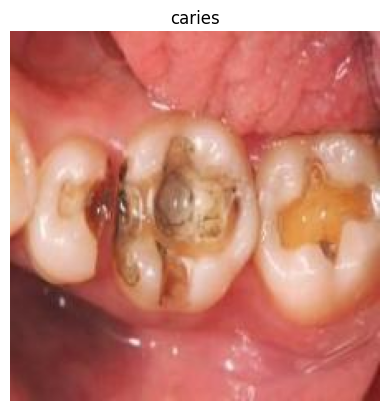

In [74]:
#viewing a sample
import torch
import matplotlib.pyplot as plt

#For same value
torch.manual_seed(42)

#Getting a random sample from the batch
random_idx = torch.randint(
    low=0,
    high=train_features_batch.size(0),
    size=(1,)
).item()

#Extracting image and label
img = train_features_batch[random_idx]      
label = train_labels_batch[random_idx]      


#Converting to H,W,C for matplotlib
img_vis = img.permute(1, 2, 0)

plt.imshow(img_vis)
plt.title(class_names[int(label)])
plt.axis("off")

# Debug / verification prints
print(f"Tensor shape: {img.shape}")      
print(f"Label index: {int(label)}")
print(f"Class name: {class_names[int(label)]}")



Creating flatten layer

In [29]:
#Creating flatten layer 
flatten_model = nn.Flatten() #flatten layer to compress dimensions of a tensor into a single vector


Creating the Convolutional Neural Network

In [30]:

class DentalDatasetCNN(nn.Module):
    """CNN for carrying out dental classification"""
    #initalizing our class 
    def __init__(self, input_shape:int, hiddent_units:int, output_shape:int):
        #initalizing our initailizer,real
        super().__init__()
        #creating in blocks [convolutional block]
        self.conv_block_1 = nn.Sequential(
            #conv2d because we are working with 2 dimensional data
            nn.Conv2d(in_channels = input_shape,
                      out_channels = hiddent_units,
                      kernel_size =3 ,
                      padding = 1) #layer 1
            
        )
            